# Gradient Boosting Trees

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
futs_df.head(2)

./data/\futures_15m.csv
(1938, 128)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,3.883,3.883,3.86,3.860,95.0,48.0,3.8709,0.023,4.184,4.184,...,1308.375,5.0,630.25,632.00,626.25,629.50,3081.0,1133.0,628.7,5.75
2023-12-29 15:45:00+00:00,3.860,3.878,3.86,3.875,18.0,14.0,3.8722,0.018,4.184,4.184,...,1304.325,3.5,629.75,631.25,628.75,629.25,996.0,468.0,630.1,2.50


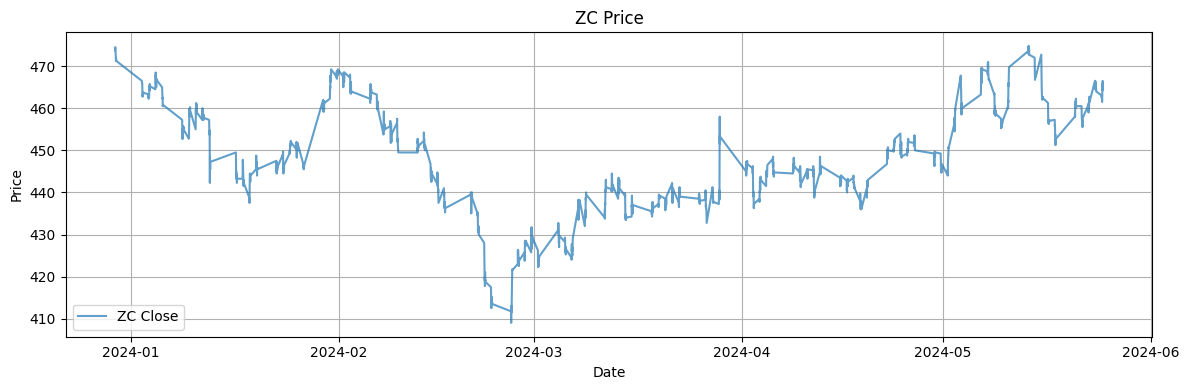

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare the Data

In [6]:
from tqdm import tqdm

from models import process_exog, process_futures, KF_COLS, BB_COLS, SR_COLS, MOM_COLS, MARKET_COLS, COLS_TO_SCALE

TEST_SPLIT = 0.7
TRAIN_SIZE = int(len(futs_df) * TEST_SPLIT)

futs_exog_df = process_exog(MARKET_FUTS, futs_df)
train_agri_ts, val_agri_ts, scalers = process_futures(AGRI_FUTS, futs_df, futs_exog_df, TRAIN_SIZE, INTERVAL)
# Stacking the lists of dataframes into single dataframes
train_ts_df = pd.concat([df.reset_index(drop=True) for df in train_agri_ts], axis=0, ignore_index=True).dropna()
test_ts_df = pd.concat([df.reset_index(drop=True) for df in val_agri_ts], axis=0, ignore_index=True).dropna()

train_ts_df.tail(5)

100%|██████████| 1221/1221 [00:00<00:00, 2536.25it/s]
kalman_backtest: 1221it [00:00, 7368.93it/s]
100%|██████████| 524/524 [00:00<00:00, 2416.52it/s]
kalman_backtest: 524it [00:00, 6265.01it/s]
100%|██████████| 1221/1221 [00:00<00:00, 2492.78it/s]
kalman_backtest: 1221it [00:00, 8088.70it/s]
100%|██████████| 524/524 [00:00<00:00, 2368.28it/s]
kalman_backtest: 524it [00:00, 7838.45it/s]
100%|██████████| 1221/1221 [00:00<00:00, 2360.07it/s]
kalman_backtest: 1221it [00:00, 7096.86it/s]
100%|██████████| 524/524 [00:00<00:00, 2283.57it/s]
kalman_backtest: 524it [00:00, 7265.17it/s]
100%|██████████| 1221/1221 [00:00<00:00, 2296.02it/s]
kalman_backtest: 1221it [00:00, 7210.21it/s]
100%|██████████| 524/524 [00:00<00:00, 2398.12it/s]
kalman_backtest: 524it [00:00, 7496.37it/s]
100%|██████████| 1221/1221 [00:00<00:00, 2277.34it/s]
kalman_backtest: 1221it [00:00, 5931.14it/s]
100%|██████████| 524/524 [00:00<00:00, 2365.80it/s]
kalman_backtest: 524it [00:00, 6186.57it/s]
100%|██████████| 1221/122

,Open,High,Low,Close,Volume,Spread,Barcount,Average,MA,U,...,Ret,Unreal_Ret,cRets,Drawdown,SD,%B,TSMOM,CONTRA,TSMOM_Shifted,CONTRA_Shifted
13555,-0.528844,-0.453408,-0.492716,-0.430500,-0.275867,0.353995,-0.146656,-0.472310,-0.123298,0.216570,...,0.0,0.0,0.0,0.0,0.728184,0.434817,1,0,1.0,0.0
13556,-0.435229,-0.453408,-0.414080,-0.414894,-0.321927,-0.493194,-0.362019,-0.427007,-0.157290,0.148278,...,0.0,0.0,0.0,0.0,0.714381,0.444595,1,0,1.0,0.0
13557,-0.419626,-0.360368,-0.382626,-0.383682,0.207762,0.184557,0.025634,-0.367646,-0.168531,0.178053,...,0.0,0.0,0.0,0.0,0.728634,0.455019,1,0,1.0,0.0
13558,-0.388421,-0.422394,-0.398353,-0.414894,-0.298897,-0.323756,-0.448164,-0.406699,-0.195909,0.121152,...,0.0,0.0,0.0,0.0,0.716835,0.453297,1,0,1.0,0.0
13559,-0.404023,-0.437901,-0.382626,-0.414894,-0.460107,-0.662632,-0.577382,-0.412948,-0.233212,-0.010780,...,0.0,0.0,0.0,0.0,0.681206,0.459506,1,0,1.0,0.0


## Feature Engineering

In [7]:
from models import META_LABEL, aug_metalabel_mr

train_ts_df = aug_metalabel_mr(train_ts_df)
test_ts_df = aug_metalabel_mr(test_ts_df)

train_ts_df[train_ts_df[META_LABEL] > 0][["Ret", META_LABEL]]

Posthoc Metalabeling: 13560it [00:00, 43859.43it/s]
Posthoc Metalabeling: 5820it [00:00, 51935.10it/s]


,Ret,mr_label
181,0.000000,1
182,0.000000,1
183,0.000000,1
184,0.000000,1
185,0.000000,1
...,...,...
12182,0.000000,1
12183,0.000000,1
12184,0.000000,1
12185,0.000000,1


# Data Clean

In [8]:
from models import clean_corr_colinear_features

ALL_COLS = np.concatenate([StockFeatExt.list, np.array(MARKET_COLS), np.array(KF_COLS), np.array(BB_COLS), np.array(SR_COLS), np.array(MOM_COLS)])

y_train = train_ts_df[META_LABEL]
X_train = train_ts_df[ALL_COLS]

y_test = test_ts_df[META_LABEL]
X_test = test_ts_df[ALL_COLS]

X_train, X_test, CLEAN_FEATURES = clean_corr_colinear_features(X_train, X_test, ALL_COLS)

These are highly corr: ['High', 'Low', 'Close', 'Barcount', 'Average', 'NQ_Open', 'ES_High', 'NQ_High', 'VXM_High', 'RTY_High', '2YY_High', '10Y_High', 'ES_Low', 'NQ_Low', 'VXM_Low', 'RTY_Low', '2YY_Low', '10Y_Low', 'ES_Close', 'NQ_Close', 'VXM_Close', 'RTY_Close', '2YY_Close', '10Y_Close', 'ES_Barcount', 'NQ_Barcount', 'RTY_Barcount', 'ES_Average', 'NQ_Average', 'VXM_Average', 'RTY_Average', '2YY_Average', '10Y_Average', 'KG_Z2', 'MA', 'U', 'L']
Multi-Colinear: ['const' 'ES_Volume' 'NQ_Volume' '10Y_Open' '2YY_Open' 'ES_Open' 'Z1'
 'Support' 'Resistance' 'VXM_Barcount' 'RTY_Open' 'NQ_Spread' 'ES_Spread'
 'Z2' 'RTY_Volume' '2YY_Barcount' 'Open' 'VXM_Volume']


# GBC

Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best parameters found: {'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 125}
Best precision score: 0.44416944142732506
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5336
           1       0.71      0.20      0.32       484

    accuracy                           0.93      5820
   macro avg       0.82      0.60      0.64      5820
weighted avg       0.91      0.93      0.91      5820



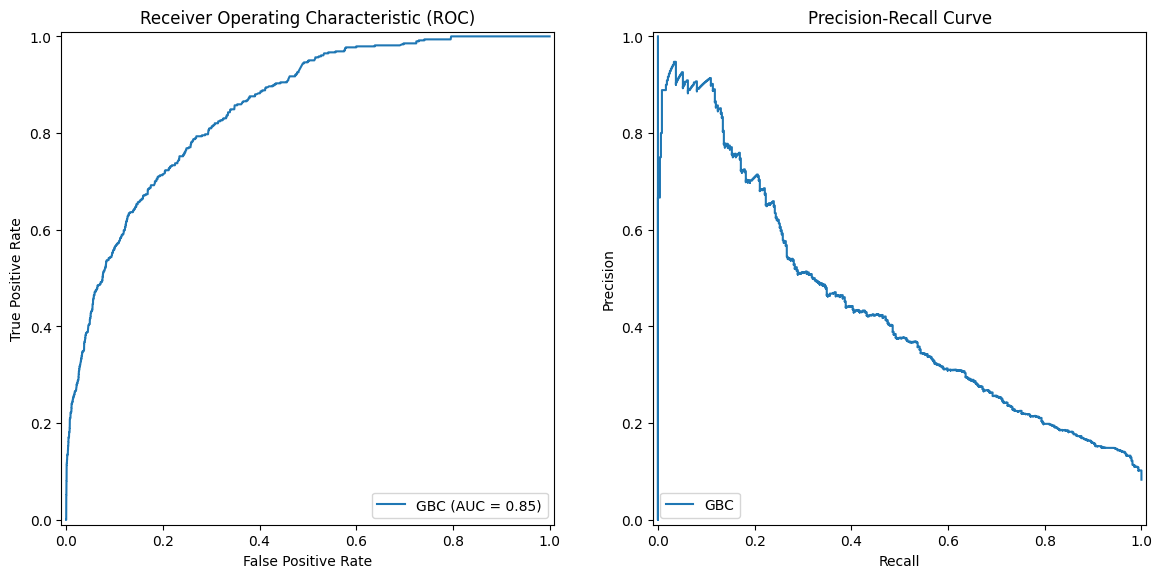

Precision: 0.7101
Recall: 0.2025
F1 Beta Score: 0.9044


In [9]:
from models import param_search, print_classification_metrics
from sklearn.ensemble import GradientBoostingClassifier

PARAM_SEARCH = True
if PARAM_SEARCH:
    gbc = param_search(X_train, y_train, X_test, y_test)
else:
    gbc = GradientBoostingClassifier(random_state=42, learning_rate=0.01, max_depth=6, n_estimators=80)
    gbc.fit(X_train, y_train)

print_classification_metrics(X_test, y_test, gbc)

# Feature Selection

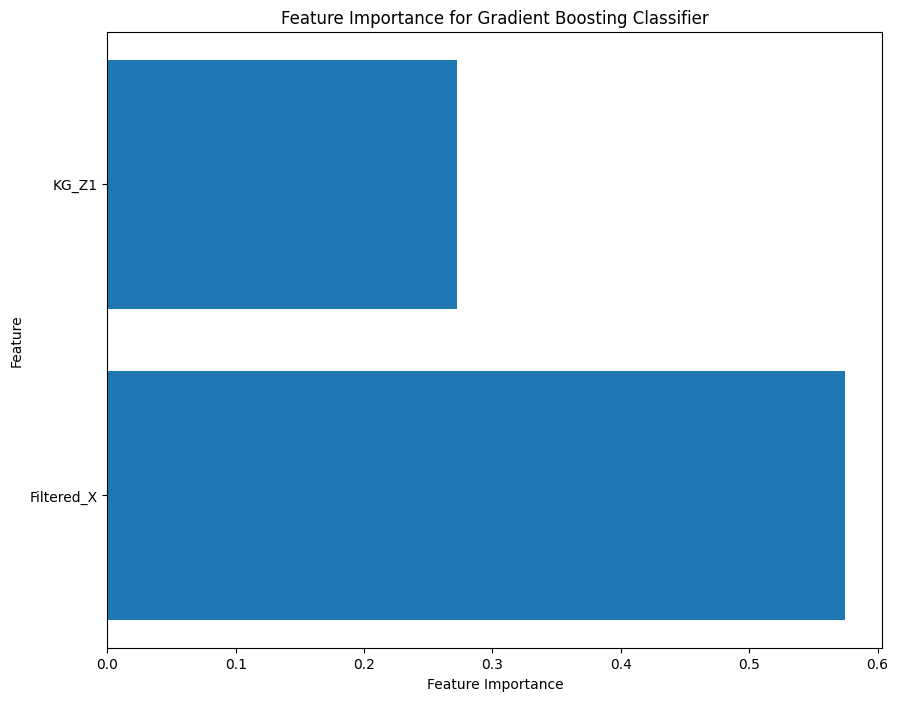

In [10]:
feature_importance = gbc.feature_importances_
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame for feature importance
gbc_feat_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
gbc_feat_df = gbc_feat_df.sort_values(by="Importance", ascending=False)
gbc_feat_df = gbc_feat_df[gbc_feat_df["Importance"] > 0.1]
plt.figure(figsize=(10, 8))
plt.barh(gbc_feat_df["Feature"], gbc_feat_df["Importance"], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Gradient Boosting Classifier')
plt.show()

## SHAP

The summary plot provides a global view of feature importance across all predictions. The SHAP value represents the impact of each feature on the model's output. 

Positive SHAP values push the prediction towards one class (mean reversion in your case), while negative SHAP values push it towards the other class (random walk).

The magnitude of the SHAP value indicates the strength of the impact. Larger absolute values mean a stronger impact on the prediction.

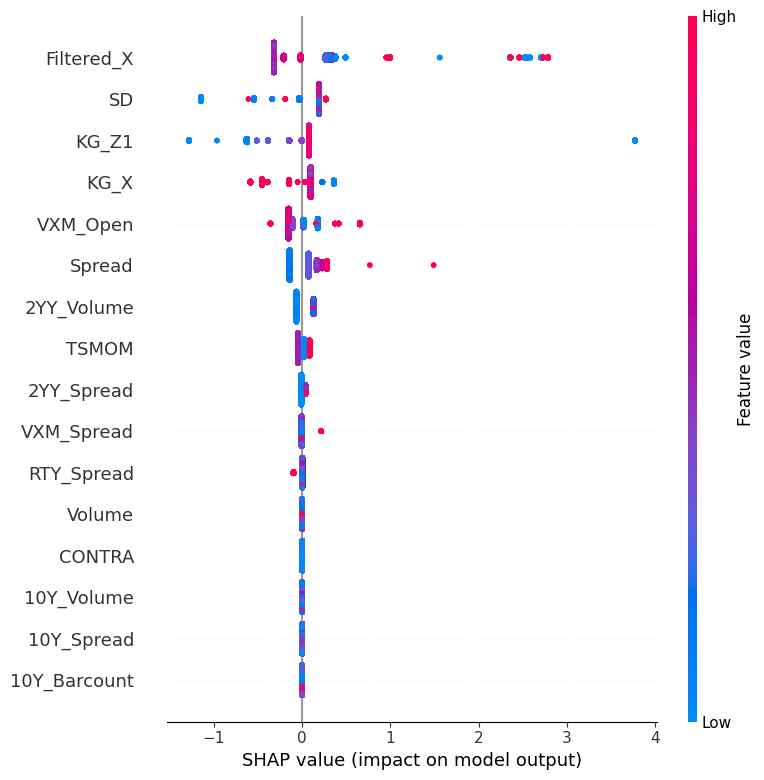

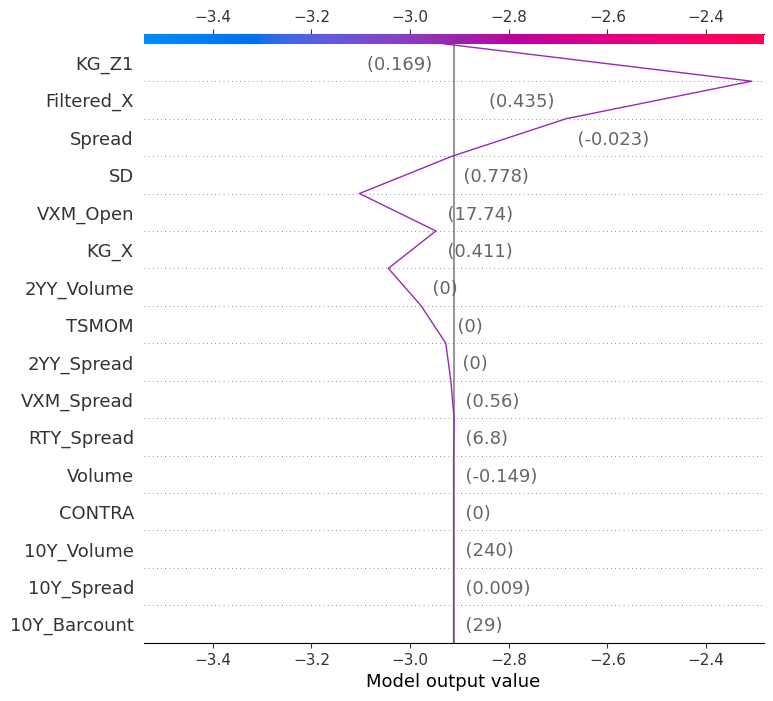

       Feature  Importance
6   Filtered_X    0.391744
10          SD    0.294420
8        KG_Z1    0.205994
7         KG_X    0.182153
13    VXM_Open    0.148782
11      Spread    0.146684
4   2YY_Volume    0.087544
12       TSMOM    0.049241
3   2YY_Spread    0.016354
14  VXM_Spread    0.008471
9   RTY_Spread    0.004944


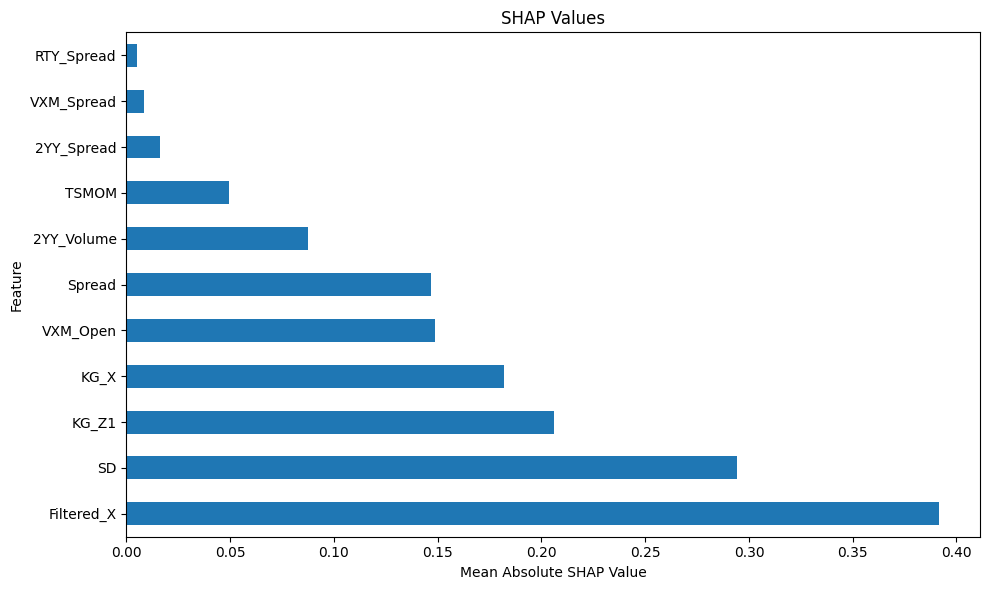

In [11]:
import shap

MAX_FEATURES_COUNT = 16

explainer = shap.Explainer(gbc, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)
shap.decision_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0])

shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': shap_importance
})
shap_importance_df = shap_importance_df.sort_values(by='Importance', ascending=False)
shap_importance_df = shap_importance_df[shap_importance_df['Importance'] > 0.001]
top_shap_features = shap_importance_df.head(MAX_FEATURES_COUNT)
print(top_shap_features)

fig, ax = plt.subplots(figsize=(10, 6))
top_shap_features.plot(kind='barh', x='Feature', y='Importance', legend=False, ax=ax)
ax.set_title(f"SHAP Values")
ax.set_xlabel("Mean Absolute SHAP Value")
ax.set_ylabel("Feature")
plt.tight_layout()
plt.show()

## PCA

Max components for 99.0% variance: 2 out of 16


,0,1
10Y_Volume,0.996453,-0.083955
10Y_Barcount,0.083853,0.985208


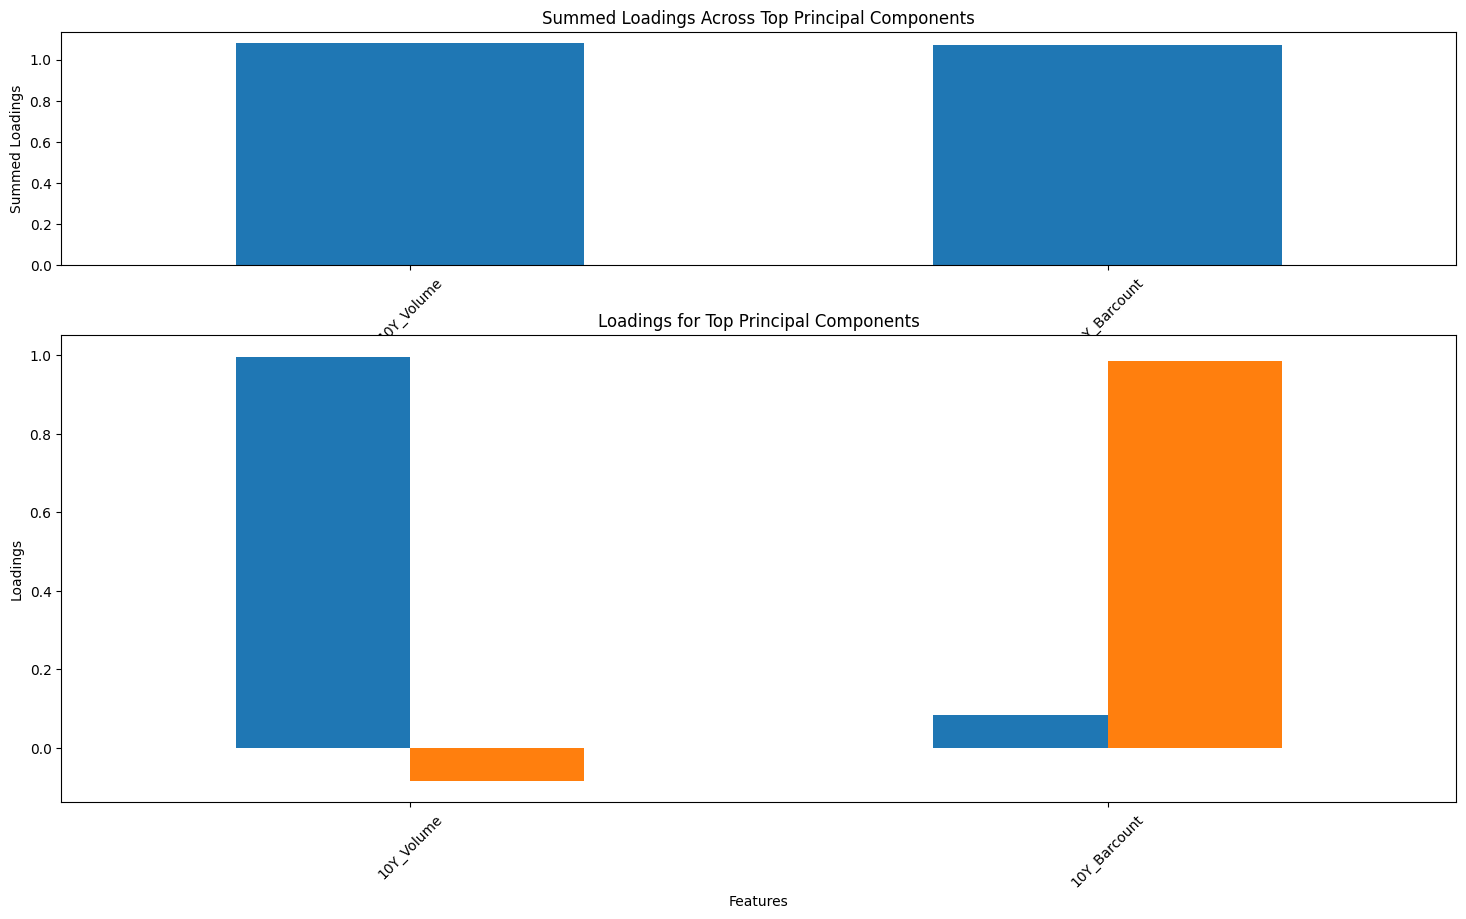

In [12]:
from sklearn.decomposition import PCA

MAX_VARIANCE = 0.99

pca = PCA()
xdata = pca.fit_transform(X_train)

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cum_var_exp >= MAX_VARIANCE) + 1
print(f"Max components for {MAX_VARIANCE*100}% variance: {num_components} out of {X_train.shape[1]}")

pca = PCA(num_components)
xdata = pca.fit_transform(X_train)
eigenvectors = pca.components_

top_features = np.abs(eigenvectors).sum(axis=0).argsort()[::-1]
selected_features = X_train.columns[top_features[:num_components]]
loadings_df = pd.DataFrame(eigenvectors[:, top_features[:num_components]], columns=selected_features).T

summed_loadings = np.sum(np.abs(eigenvectors[:, top_features[:num_components]]), axis=0)
summed_loadings_df = pd.DataFrame(summed_loadings, index=selected_features, columns=["Sum"]).sort_values(by="Sum", ascending=False)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 2]})

summed_loadings_df.plot(kind="bar", legend=False, ax=axes[0])
axes[0].set_title("Summed Loadings Across Top Principal Components")
axes[0].set_ylabel("Summed Loadings")
axes[0].set_xlabel("Features")
axes[0].tick_params(axis='x', labelrotation=45)

loadings_df.plot(kind="bar", legend=False, ax=axes[1])
axes[1].set_title(f"Loadings for Top Principal Components")
axes[1].set_ylabel("Loadings")
axes[1].set_xlabel("Features")
axes[1].tick_params(axis='x', labelrotation=45)

loadings_df

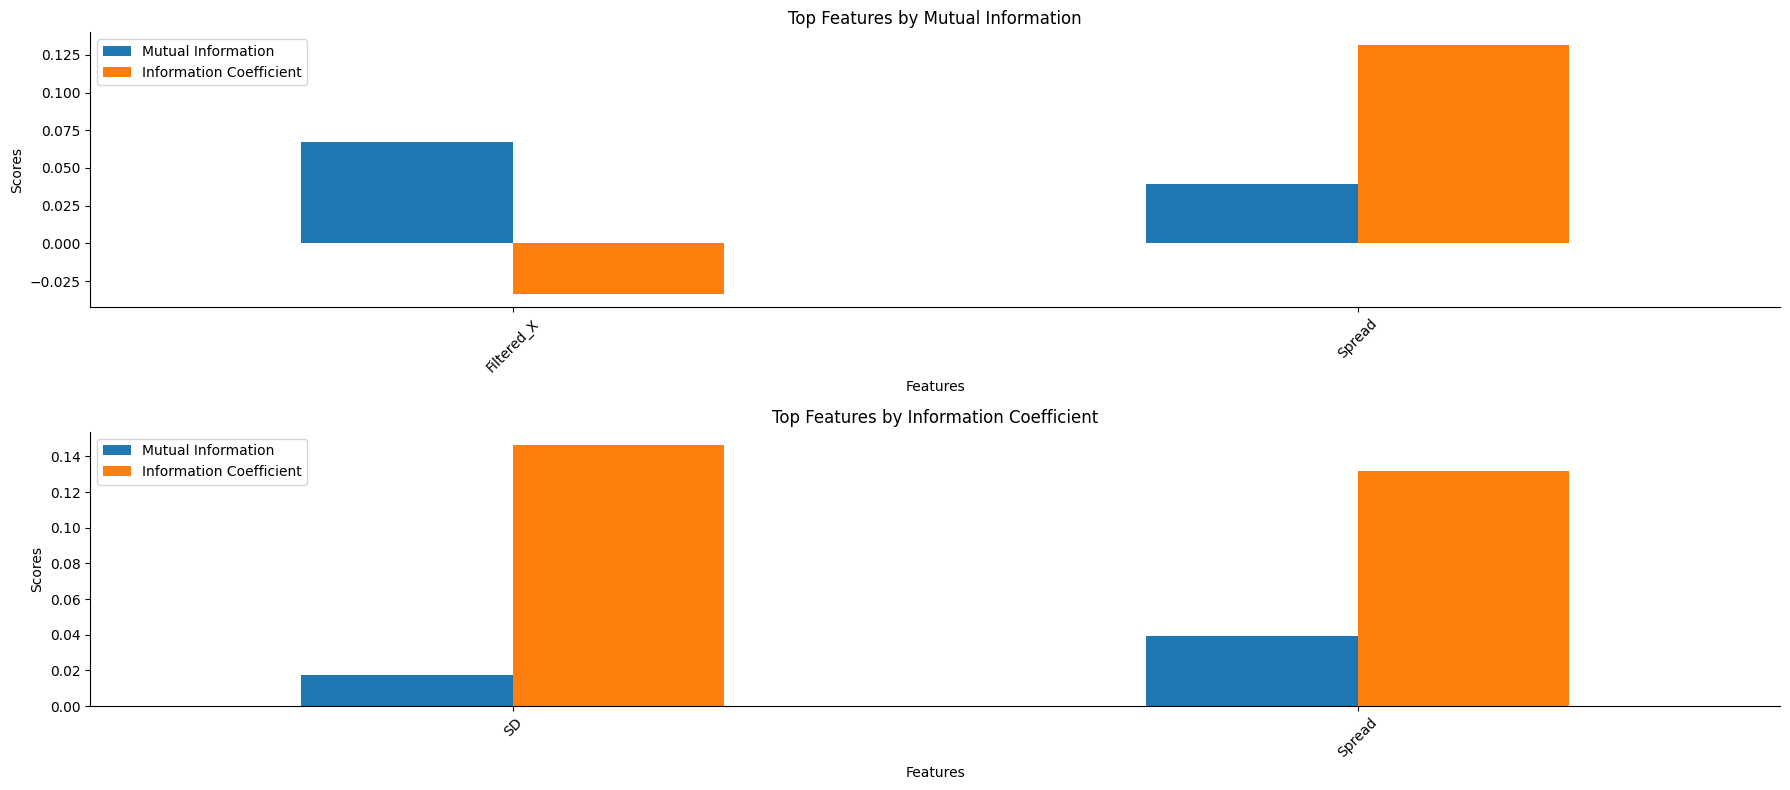

In [13]:
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

ic = {}
for column in X_train.columns:
    corr, p_val = spearmanr(y_train, X_train[column])
    ic[column] = [corr, p_val]
ic_df = pd.DataFrame(ic, index=["IC", "p-value"]).T

mi = mutual_info_regression(X=X_train, y=y_train)
mi_series = pd.Series(mi, index=X_train.columns)
metrics = pd.concat(
    [
        mi_series.to_frame("Mutual Information"),
        ic_df["IC"].to_frame("Information Coefficient"),
    ],
    axis=1,
)

top_mi_features = metrics.sort_values(by="Mutual Information", ascending=False).head(num_components)
top_ic_features = metrics.sort_values(by="Information Coefficient", ascending=False).head(num_components)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

top_mi_features.plot.bar(ax=axes[0], rot=45)
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Scores")
axes[0].set_title("Top Features by Mutual Information")
axes[0].tick_params(axis='x', labelrotation=45)
sns.despine(ax=axes[0])

top_ic_features.plot.bar(ax=axes[1], rot=45)
axes[1].set_xlabel("Features")
axes[1].set_ylabel("Scores")
axes[1].set_title("Top Features by Information Coefficient")
axes[1].tick_params(axis='x', labelrotation=45)
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

In [14]:
features_pca = summed_loadings_df.head(MAX_FEATURES_COUNT).index.tolist()
features_miic = (metrics.head(MAX_FEATURES_COUNT).index.tolist())
features_shap  = (shap_importance_df.head(MAX_FEATURES_COUNT)['Feature'].tolist())
features_gbc = (gbc_feat_df.head(MAX_FEATURES_COUNT)['Feature'].tolist())

print(F"Top {MAX_FEATURES_COUNT} PCA Loadings: {features_pca}")
print(F"Top {MAX_FEATURES_COUNT} MI/IC: {features_miic}")
print(F"Top {MAX_FEATURES_COUNT} SHAP: {features_shap}")
print(F"Top {MAX_FEATURES_COUNT} GBC: {features_gbc}")

DIMREDUC_FEATURES = list(set(features_pca) | set(features_miic) | set(features_shap) | set(features_gbc))

print(f"Selected {len(DIMREDUC_FEATURES)} features: {DIMREDUC_FEATURES}")

Top 16 PCA Loadings: ['10Y_Volume', '10Y_Barcount']
Top 16 MI/IC: ['10Y_Barcount', '10Y_Spread', '10Y_Volume', '2YY_Spread', '2YY_Volume', 'CONTRA', 'Filtered_X', 'KG_X', 'KG_Z1', 'RTY_Spread', 'SD', 'Spread', 'TSMOM', 'VXM_Open', 'VXM_Spread', 'Volume']
Top 16 SHAP: ['Filtered_X', 'SD', 'KG_Z1', 'KG_X', 'VXM_Open', 'Spread', '2YY_Volume', 'TSMOM', '2YY_Spread', 'VXM_Spread', 'RTY_Spread']
Top 16 GBC: ['Filtered_X', 'KG_Z1']
Selected 16 features: ['10Y_Barcount', 'KG_Z1', 'Volume', 'VXM_Open', '2YY_Volume', 'Filtered_X', '10Y_Volume', 'SD', '2YY_Spread', '10Y_Spread', 'VXM_Spread', 'CONTRA', 'Spread', 'TSMOM', 'KG_X', 'RTY_Spread']


## Dimension Reduction

Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best parameters found: {'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 25}
Best precision score: 0.5
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5336
           1       0.00      0.00      0.00       484

    accuracy                           0.92      5820
   macro avg       0.46      0.50      0.48      5820
weighted avg       0.84      0.92      0.88      5820



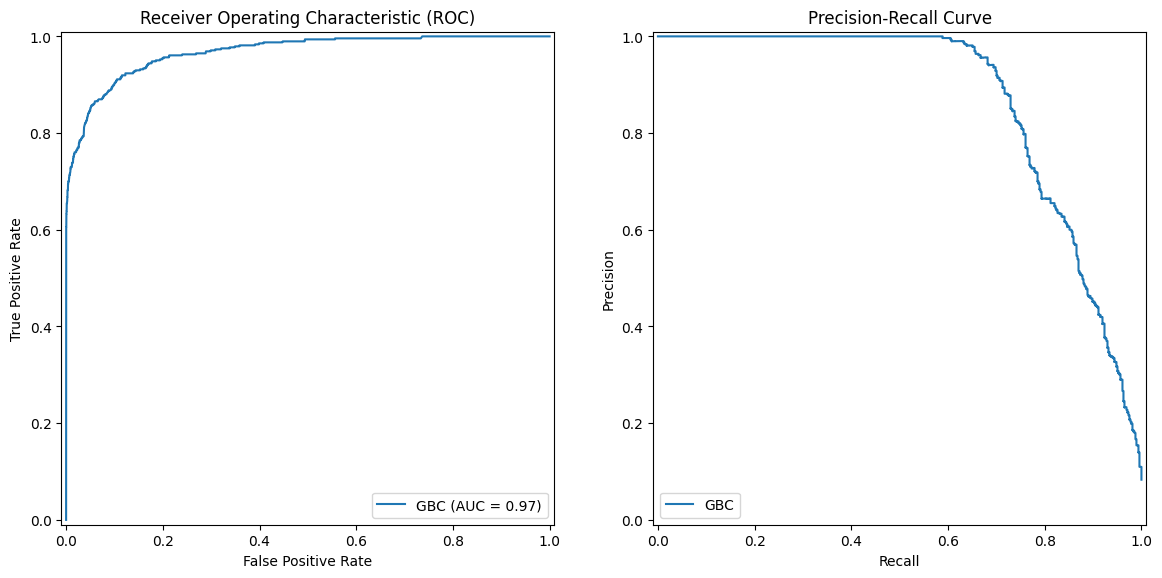

Precision: 0.0000
Recall: 0.0000
F1 Beta Score: 0.8548


In [15]:
X_train_dimreduc = X_train[DIMREDUC_FEATURES]
X_test_dimreduc = X_test[DIMREDUC_FEATURES]
if PARAM_SEARCH:
    gbc_dimreduc = param_search(X_train_dimreduc, y_train, X_test_dimreduc, y_test)
else:
    gbc_dimreduc = GradientBoostingClassifier(random_state=42, learning_rate=0.01, max_depth=3, n_estimators=300)
    gbc_dimreduc.fit(X_train_dimreduc, y_train)
print_classification_metrics(X_test_dimreduc, y_test, gbc_dimreduc)

# Rebalancing Dataset

## SMOTE

Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best parameters found: {'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 25}
Best precision score: 0.5577777777777778
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5336
           1       0.65      0.57      0.61       484

    accuracy                           0.94      5820
   macro avg       0.80      0.77      0.79      5820
weighted avg       0.94      0.94      0.94      5820



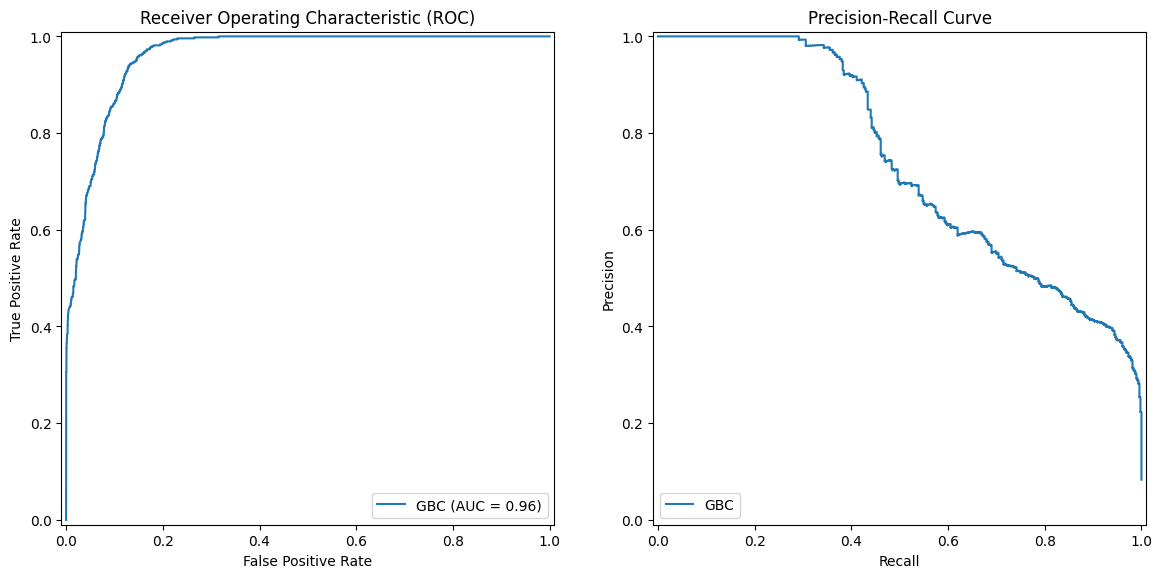

Precision: 0.6472
Recall: 0.5723
F1 Beta Score: 0.9359


In [16]:
from imblearn.over_sampling import ADASYN
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

X_train_resampled, y_train_resampled = ADASYN(sampling_strategy="minority",n_neighbors=7).fit_resample(X_train, y_train)
if PARAM_SEARCH:
    gbc_smote = param_search(X_train_resampled, y_train_resampled, X_test, y_test)
else:
    gbc_smote = GradientBoostingClassifier(random_state=42, learning_rate=0.02, max_depth=6, n_estimators=25)
    gbc_smote.fit(X_train_resampled, y_train_resampled)
print_classification_metrics(X_test, y_test, gbc_smote)

# Validation

In [17]:
SELECTED_MODEL = gbc

In [60]:
from sklearn.preprocessing import StandardScaler
from models import augment_ts

def backtest_gbc(df, gbc_model, model_features=DIMREDUC_FEATURES, model_early_exit=True):
    position = 0

    df[META_LABEL] = gbc_model.predict(df[model_features])
    df['Ret'] = 0
    df['Closed'] = 0
    df['Position'] = 0
    df['Unreal_Ret'] = 0
    df['cRets'] = 0
    df['SCancelled'] = 0

    for i, row in tqdm(df.iterrows(), desc="gbc_backtest"):
        if ((row['SBS'] == -1 and position == 1) or \
            (row['SSB'] == 1 and position == -1) or \
            (position == 1 and row['Close'] <= entry * (1 - 0.1)) or \
            (position == -1 and row['Close'] >= entry * (1 + 0.1))):

            if position == 1:
                df.loc[i, 'Ret'] = (row['Close'] - entry) / entry
                df.loc[i, 'Closed'] = 1
            else:
                df.loc[i, 'Ret'] = (entry - row['Close']) / entry
                df.loc[i, 'Closed'] = -1
            position = 0
        elif ((row['SBS'] == 1 and position == 0) or (row['SSB'] == -1 and position == 0)):
            # it was cancelled.
            df.loc[i, 'SBS'] = df.loc[i, 'SSB'] = 0

        if ((row['SB'] == 1 and position == 0) or (row['SS'] == -1 and position == 0)):
            if row[META_LABEL] :
                entry = row['Close']
                position = 1 if row['SB'] == 1 else -1
            else:
                df.loc[i, 'SB'] = df.loc[i, 'SS'] = 0
                df.loc[i, 'SCancelled'] = 1 # use LIME to understand

        df.loc[i, 'Position'] = position
        if position != 0:
            # Unrealized for continuous returns tracking.
            df.loc[i, 'Unreal_Ret'] = (entry - row['Close']) / entry
            if model_early_exit and not row[META_LABEL]:
                if position == 1:
                    df.loc[i, 'Ret'] = (row['Close'] - entry) / entry
                    df.loc[i, 'Closed'] = 1
                    df.loc[i, 'SBS'] = 1
                else:
                    df.loc[i, 'Ret'] = (entry - row['Close']) / entry
                    df.loc[i, 'Closed'] = -1
                    df.loc[i, 'SSB'] = 1
                position = 0

    df['cRets'] = (1 + df['Ret']).cumprod() - 1
    return df

# Since we stacked the same timeseries, we can unstack to get the first actual future TS.
# Also descale it to compare, and rescale it for classification.
fut_df = futs_df.filter(regex=f"{LEANHOG_FUT}_.*")
fut_df.columns = fut_df.columns.str.replace(f"{LEANHOG_FUT}_", "", regex=False)
fut_df = pd.concat([fut_df, futs_exog_df], axis=1)
fut_df = fut_df.loc[:, ~fut_df.columns.duplicated(keep="first")]
single_test_df, scaler = augment_ts(fut_df.iloc[TRAIN_SIZE:],
                                    StockFeat.CLOSE, StockFeat.HIGH,
                                    StockFeat.LOW, StockFeat.VOLUME,
                                    INTERVAL)
single_test_df = single_test_df.loc[:, ~single_test_df.columns.duplicated(keep="first")]
print(single_test_df.shape)

bt_df = backtest_gbc(single_test_df, SELECTED_MODEL, model_features=CLEAN_FEATURES)

100%|██████████| 524/524 [00:00<00:00, 1930.60it/s]
kalman_backtest: 524it [00:00, 6867.19it/s]


(582, 91)


gbc_backtest: 582it [00:00, 7655.33it/s]


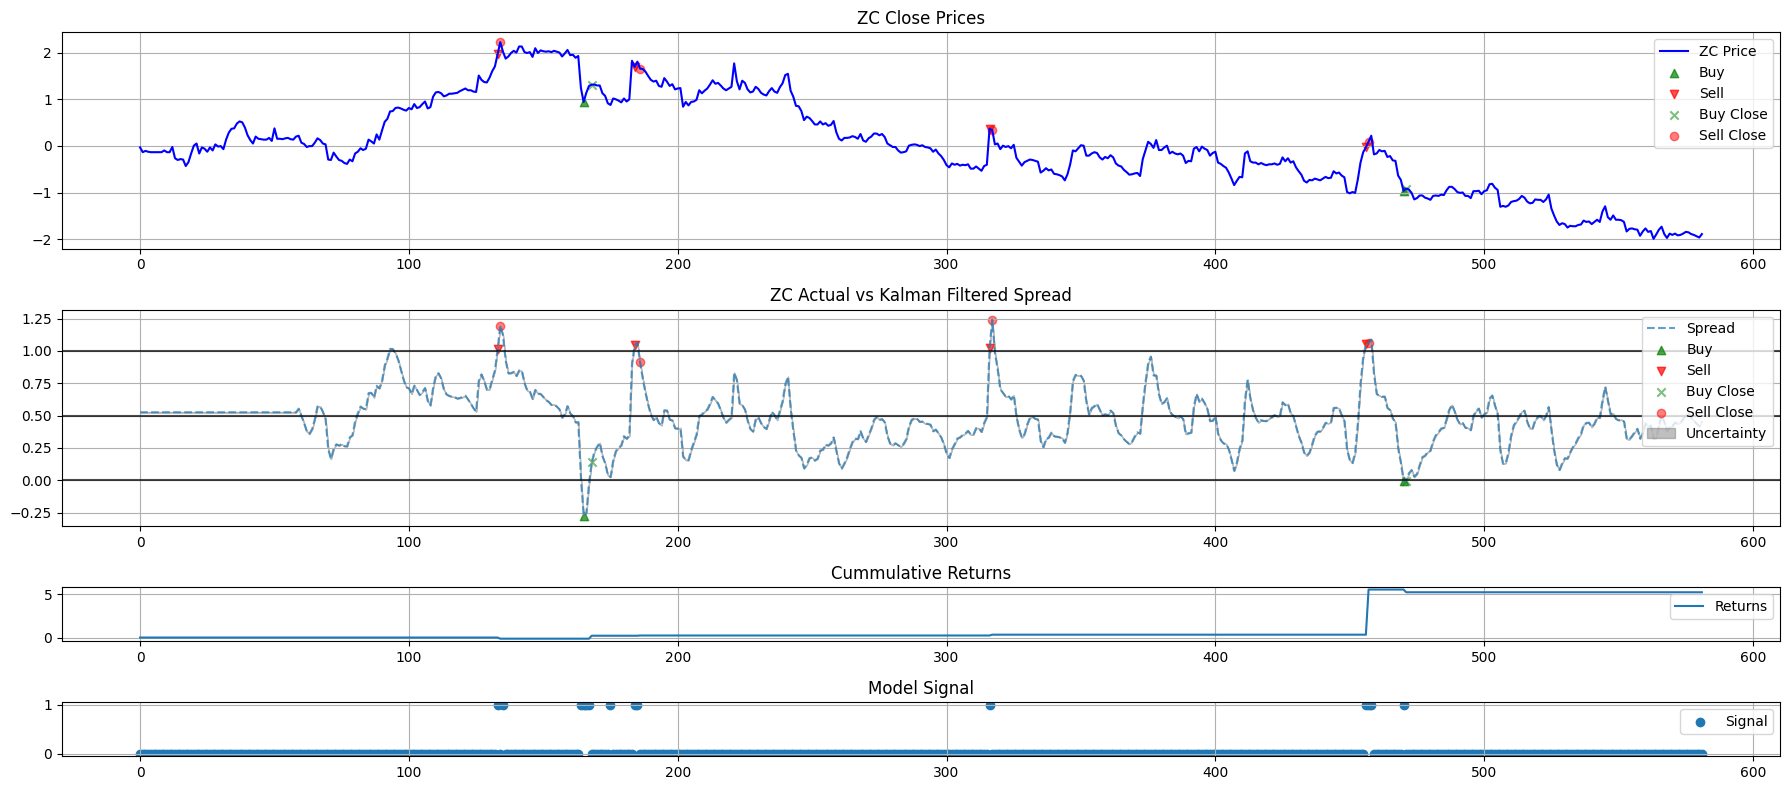

In [61]:
def plot(bt_df, zoom=None):
    fig, axs = plt.subplots(4, gridspec_kw={'height_ratios': [4, 4, 1, 1]}, figsize=(18, 8))

    if zoom is not None:
        assert len(bt_df) > zoom[1], f"{len(bt_df)} >  Zoom: {zoom}"
        bt_df = bt_df.iloc[zoom[0]:zoom[1]]

    buy_signals = bt_df[bt_df['SB'] > 0]
    sell_signals = bt_df[bt_df['SS'] < 0]
    long_closed = bt_df[bt_df['Closed'] > 0]
    short_closed = bt_df[bt_df['Closed'] < 0]

    axs[0].plot(bt_df['Close'].index, bt_df['Close'], label=f'{AGRI_FUTS[0]} Price', color='blue')
    axs[0].scatter(buy_signals.index, buy_signals[f'Close'], color='green', marker='^', label='Buy', alpha =0.7)
    axs[0].scatter(sell_signals.index, sell_signals[f'Close'], color='red', marker='v', label='Sell', alpha =0.7)
    axs[0].scatter(long_closed.index, long_closed[f'Close'], color='green', marker='x', label='Buy Close', alpha =0.5)
    axs[0].scatter(short_closed.index, short_closed[f'Close'], color='red', marker='o', label='Sell Close', alpha =0.5)
    axs[0].set_title(f'{AGRI_FUTS[0]} Close Prices')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(bt_df.index, bt_df['Filtered_X'], label='Spread', alpha=0.7, linestyle='--')
    axs[1].scatter(buy_signals.index, buy_signals[f'Filtered_X'], color='green', marker='^', label='Buy', alpha =0.7)
    axs[1].scatter(sell_signals.index, sell_signals[f'Filtered_X'], color='red', marker='v', label='Sell', alpha =0.7)
    axs[1].scatter(long_closed.index, long_closed[f'Filtered_X'], color='green', marker='x', label='Buy Close', alpha =0.5)
    axs[1].scatter(short_closed.index, short_closed[f'Filtered_X'], color='red', marker='o', label='Sell Close', alpha =0.5)
    axs[1].fill_between(bt_df.index,
                        bt_df['Filtered_X'] - bt_df['Uncertainty'],
                        bt_df['Filtered_X'] + bt_df['Uncertainty'],
                        label='Uncertainty', color="gray", alpha=0.5)
    axs[1].axhline(y=1., color='black', alpha=0.7)
    axs[1].axhline(y=0.5, color='black', alpha=0.7)
    axs[1].axhline(y=0., color='black', alpha=0.7)
    axs[1].set_title(f'{TARGET_FUT} Actual vs Kalman Filtered Spread')
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(bt_df.index, bt_df['cRets'], label='Returns')
    axs[2].set_title(f'Cummulative Returns')
    axs[2].grid(True)
    axs[2].legend()

    axs[3].scatter(bt_df.index, bt_df[META_LABEL], label='Signal')
    axs[3].set_title(f'Model Signal')
    axs[3].grid(True)
    axs[3].legend()

    plt.tight_layout()
    plt.show()

plot(bt_df)

## Why Decisions?

In [62]:
samples = single_test_df.iloc[50:100]
sample_cancelled = samples[samples["SCancelled"] == 1][CLEAN_FEATURES]
samples = samples[CLEAN_FEATURES]

print(sample_cancelled.shape)
sample_cancelled

(1, 16)


,10Y_Barcount,10Y_Spread,10Y_Volume,2YY_Spread,2YY_Volume,CONTRA,Filtered_X,KG_X,KG_Z1,RTY_Spread,SD,Spread,TSMOM,VXM_Open,VXM_Spread,Volume
93,2.0,0.006,8.0,0.0,0.0,0,1.015578,0.444608,0.281615,6.3,0.869366,1.049783,0,17.5,0.17,0.564678


# LIME Explanations

In [63]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(samples.values, feature_names=samples.columns, class_names=['RW', 'MR'], discretize_continuous=True)
exp = explainer.explain_instance(sample_cancelled.values[0], SELECTED_MODEL.predict_proba, num_features=len(single_test_df.columns))
exp.show_in_notebook(show_table=True)


In [64]:
samples = single_test_df.iloc[460:500]
sample_cancelled = samples[samples[META_LABEL] == 1][CLEAN_FEATURES]
samples = samples[CLEAN_FEATURES]

print(sample_cancelled.shape)
sample_cancelled

(1, 16)


,10Y_Barcount,10Y_Spread,10Y_Volume,2YY_Spread,2YY_Volume,CONTRA,Filtered_X,KG_X,KG_Z1,RTY_Spread,SD,Spread,TSMOM,VXM_Open,VXM_Spread,Volume
470,23.0,0.006,95.0,0.0,1.0,0,-0.002364,0.440093,0.260514,4.4,0.84309,1.654607,0,13.75,0.04,1.04965


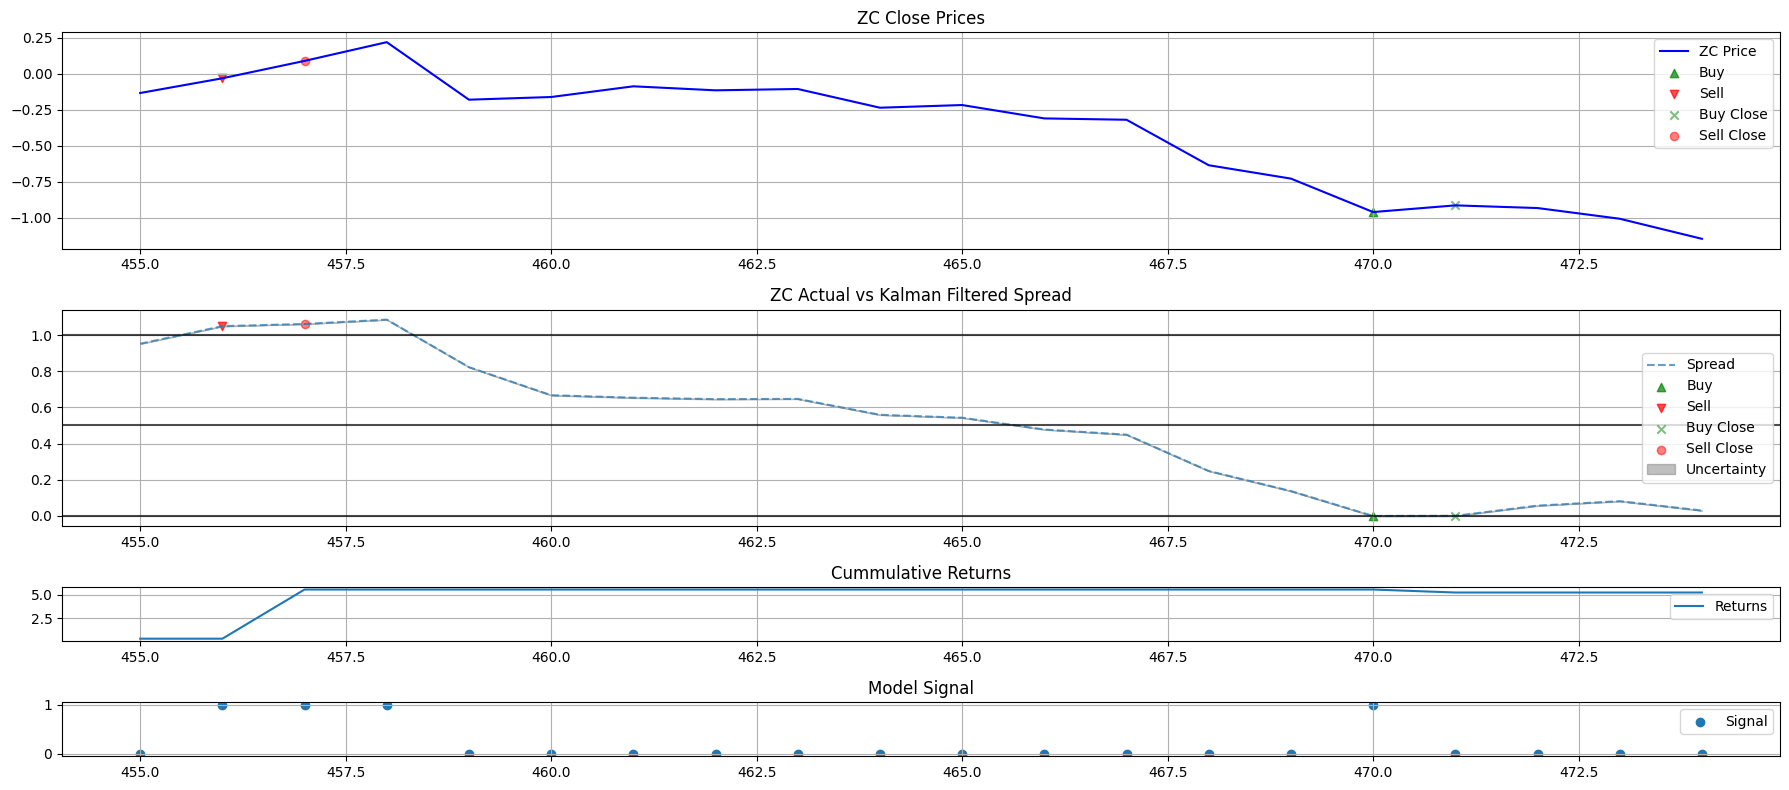

In [68]:
plot(bt_df, zoom=[455, 475])

In [66]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(samples.values, feature_names=samples.columns, class_names=['RW', 'MR'], discretize_continuous=True)
exp = explainer.explain_instance(sample_cancelled.values[0], SELECTED_MODEL.predict_proba, num_features=len(single_test_df.columns))
exp.show_in_notebook(show_table=True)
